In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from qiskit import *
from itertools import product
from qulacsvis import circuit_drawer
from mpl_axes_aligner import shift
from qiskit.quantum_info.states.random import random_density_matrix
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qulacs.gate import CNOT, RX, RY, RZ
import matplotlib.pyplot as plt
plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.size": 10}
)
def dictionary_of_actions(num_qubits):
    dictionary = dict()
    i = 0
    for c, x in product(range(num_qubits),
                        range(1, num_qubits)):
        dictionary[i] =  [c, x, num_qubits, 0]
        i += 1
    for r, h in product(range(num_qubits),
                           range(1, 4)):
        dictionary[i] = [num_qubits, 0, r, h]
        i += 1
    return dictionary

def make_circuit_qiskit(action, qubits):
    ctrl = action[0]
    targ = (action[0] + action[1]) % qubits
    rot_qubit = action[2]
    rot_axis = action[3]
    if ctrl < qubits:
        circuit.cx([ctrl], [targ])
    if rot_qubit < qubits:
        if rot_axis == 1:
            circuit.rx(0, rot_qubit) # TODO: make a function and take angles
        elif rot_axis == 2:
            circuit.ry(0, rot_qubit)
        elif rot_axis == 3:
            circuit.rz(0, rot_qubit)
        else:
            stop
    return circuit

In [13]:
qubits, rank, seed_agent = 3,8,102
episodes = 10000
tolerance = 1e-4
test_train = 'train'
data = np.load(f'results/global_COBYLA/h_s_{qubits}_reduce_heisen/summary_{seed_agent}.npy',allow_pickle=True)[()]

succ_ep_info_dict = {}
success_ep, success_ep_error = [], []
average_err = 0
for ep_no in range(episodes):
    data_error_last = data[test_train][ep_no]['errors'][-1]
    if data_error_last <= tolerance:
        success_ep.append(ep_no)
        success_ep_error.append(data_error_last)
        average_err += data_error_last
average_err /= len(success_ep)
print(f'First successful episode: {success_ep[0]} and error {round(success_ep_error[0],6)}, total successful episode: {len(success_ep)}')

succ_ep_info_dict['succ_ep_list'] = success_ep
succ_ep_info_dict['succ_ep_err_list'] = success_ep_error

with open(f'plot_data/{qubits}_qubit_mixed_rank_{rank}_agent_seed_{seed_agent}_succ_ep_data.p', 'wb') as fp:
    pickle.dump(succ_ep_info_dict, fp)

x = [data[test_train][ep_no]['actions'] for ep_no in success_ep]
circuit_info_dict = {}
depth_list = []
oneq_gate_list = []
twoq_gate_list = []
gate_num_list = []
# depth list:
for succ_ep in success_ep:
    actions = data[test_train][succ_ep]['actions']
    circuit = QuantumCircuit(qubits)
    for a in actions:
        action = dictionary_of_actions(qubits)[a]
#         print(action)
        final_circuit = make_circuit_qiskit(action, qubits)
#     print(final_circuit)
    gate_info = final_circuit.count_ops()
    key_list = gate_info.keys()
    one_gate, two_gate = 0,0
    for k in key_list:
        if k == 'cx':
            two_gate += gate_info[k]
        else:
            one_gate += gate_info[k]

    twoq_gate_list.append(two_gate)
    oneq_gate_list.append(one_gate)
    gate_num_list.append(one_gate+two_gate)        
    depth_list.append(final_circuit.depth())

circuit_info_dict['depth_list'] = depth_list
circuit_info_dict['oneq_gate_list'] = oneq_gate_list
circuit_info_dict['twoq_gate_list'] = twoq_gate_list
circuit_info_dict['gate_num_list'] = gate_num_list
with open(f'plot_data/{qubits}_qubit_mixed_rank_{rank}_agent_seed_{seed_agent}_circuit_data.p', 'wb') as fp:
    pickle.dump(circuit_info_dict, fp)

First successful episode: 32 and error 2.4e-05, total successful episode: 2947


In [4]:
print(f'The average depth is: {np.mean(depth_list)}, minimum depth: {min(depth_list)}, 1st-depth: {depth_list[0]}, 100-depth: {np.mean(depth_list[0:100])}')
print(f'The average gate count: ROT={np.mean(oneq_gate_list)},CX={np.mean(twoq_gate_list)}')
print(f'The min gate count: ROT={oneq_gate_list[gate_num_list.index(min(gate_num_list))]},CX={twoq_gate_list[gate_num_list.index(min(gate_num_list))]}')
success_ep_error[gate_num_list.index(min(gate_num_list))]

The average depth is: 20.324737020699015, minimum depth: 12, 1st-depth: 24, 100-depth: 20.29
The average gate count: ROT=20.11672887682389,CX=11.434340006786563
The min gate count: ROT=11,CX=8


4.2992666795915735e-05

In [5]:
succ_ep = success_ep[gate_num_list.index(min(gate_num_list))]
thetas = data['train'][succ_ep]['opt_ang']
thetas = list(thetas[-1])

In [6]:
def eigenvals_func(theta, rdm, ansatz):
    """Return the eigenvalues"""
    qc_eigenvals = ansatz
    dm_evo = rdm.evolve(qc_eigenvals)
    dm_evo = dm_evo.data
    diagnls = list((np.diagonal(dm_evo)).real)
    diag_A = []
    diag_A.append(diagnls)
    return diag_A, dm_evo, qc_eigenvals

In [17]:
import scipy.linalg as la
state_data = []
with (open(f"state_data/{qubits}_qubit_reduce_heisen_model_state_data.p", "rb")) as openfile:
    while True:
        try:
            state_data.append(pickle.load(openfile))
        except EOFError:
            break
state_to_diag_gen = state_data[0]['state']
true_eig = np.sort(la.eig(state_to_diag_gen)[0].real)
print(true_eig)
err_list = []
gates = oneq_gate_list[gate_num_list.index(min(gate_num_list))] + \
        twoq_gate_list[gate_num_list.index(min(gate_num_list))]
gates_list = range(1, gates+1)
inf_eig_list = []
for g in gates_list:
    final_circuit = QuantumCircuit.from_qasm_str(data['train'][succ_ep]['save_circ'][-1])

    ansatz =QuantumCircuit(qubits)
    for i in final_circuit.data:
        if i[0].name == 'cx':
            ansatz.cx(i[1][0].index, i[1][1].index)
        if i[0].params != [0]:
            if i[0].name == 'rx':
                ansatz.rx(i[0].params[0], i[1][0].index)
            elif i[0].name == 'ry':
                ansatz.ry(i[0].params[0], i[1][0].index)
            elif i[0].name == 'rz':
                ansatz.rz(i[0].params[0], i[1][0].index)

    ansatz.data = ansatz[:g]
    inf_eig = np.sort(eigenvals_func(thetas, state_to_diag_gen, ansatz)[0])[0]
    inf_eig_list.append(inf_eig)
    
    #### ERROR IN EIGENVALUE CALCULATION ####
    err = 0
    for eigno in range(2**qubits):
        err += np.abs(inf_eig[eigno] - true_eig[eigno])**2
    err_list.append(err)
#     print(err)

[0.0007966  0.00079669 0.01044492 0.01045802 0.02698639 0.0269977
 0.46167581 0.46184387]
0.08287347274406365
0.08287347274406365
0.02149738889393448
0.02182866086005039
0.02318571924410589


/tmp/ipykernel_389007/3478344344.py:23: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  ansatz.cx(i[1][0].index, i[1][1].index)
/tmp/ipykernel_389007/3478344344.py:28: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  ansatz.ry(i[0].params[0], i[1][0].index)
/tmp/ipykernel_389007/3478344344.py:26: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  ansatz.rx(i[0].params[0], i[1][0].index)
/tmp/ipykernel_389007/3478344344.py:30: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  ansatz.rz(i[0].params[0], i[1][0].index)


0.02283413878281222
0.022834138782812218
0.022834138782812218
0.022834136309272883
0.022834136309272883
0.002399775705215977
0.0023997725886037834
0.0023997725886037834
0.0023997725192857673
0.0023997725192857673
0.0023997725192857673
0.0023997725192857642
0.00020024227409892926
0.00020024227409892926


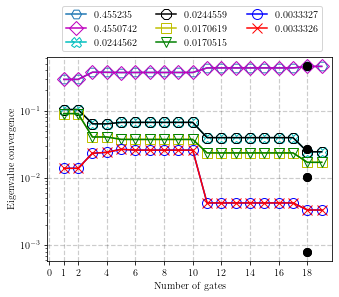

In [20]:
line_type = ['r-x', 'b-o', 'g-v', 'y-s', 'k-8', 'c-X', 'm-D', '-H']
fig = plt.figure(layout='constrained', figsize=(4.6, 4))
ax = fig.add_subplot(111)
for eigel in reversed(range(2**qubits)):
    x = np.asarray(inf_eig_list)[:,eigel]
    ax.semilogy(list(range(1,gates+1,1)), x, line_type[eigel], markerfacecolor='none', ms=10, label = f'{round(x[-1],7)}')

for true_eigel in true_eig:
    ax.plot([gates-1], [true_eigel], 'ko', ms=8)

ax.set_xticks([1]+list(range(0,gates+1,2)))
org = 0.46  # Origin
pos = 9  # Position the origins is aligned
expand = True  # Switch the aligning method
shift.xaxis(ax, pos, org)
ax.legend(ncol = 3, bbox_to_anchor=[0.98, 1.27])
ax.set_xlabel('Number of gates')
ax.set_ylabel('Eigenvalue convergence')
ax.grid(color='k', linestyle='--', linewidth=1.2, alpha = 0.2)
# plt.savefig(f'plot/{qubits}_qubits_eigenvalue_convergence_seed_{seed_agent}.pdf')
# plt.savefig(f'plot/{qubits}_qubits_eigenvalue_convergence_seed_{seed_agent}.png')